Rotation Invariant MNIST Model
===
The idea of this model is to make it rotation invariant, or in other words, able to identified images at different rotations. So first we will created some rotated training data by rotating all of the mnist images at different angles, then we will create a model that is rotation invariant and train it on the data.

Autosaving every 60 seconds
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


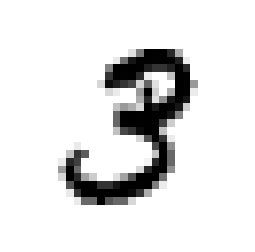

Rotating images with shape (55000, 28, 28, 1) for angle 90.0
Rotating images with shape (55000, 28, 28, 1) for angle 180.0
Rotating images with shape (55000, 28, 28, 1) for angle 270.0
Rotating images with shape (5000, 28, 28, 1) for angle 90.0
Rotating images with shape (5000, 28, 28, 1) for angle 180.0
Rotating images with shape (5000, 28, 28, 1) for angle 270.0
Rotating images with shape (10000, 28, 28, 1) for angle 90.0
Rotating images with shape (10000, 28, 28, 1) for angle 180.0
Rotating images with shape (10000, 28, 28, 1) for angle 270.0
1


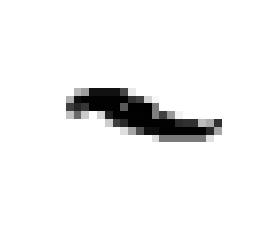

Finished generating images


In [1]:
%autosave 60

import math
import pickle
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# set random seed for deterministic results.
np.random.seed(0)
tf.set_random_seed(0)

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()

def flatten(list_of_lists):
    return [element for a_list in list_of_lists for element in a_list]

some_digit = mnist.train.images[1]
show_image(some_digit.reshape(28, 28))

def degrees_to_radians(degrees):
    return degrees * math.pi / 180.0

def generate_rotate_images(images, angle_in_degrees):
    expected_rank = 4
    if len(images.shape) != expected_rank:
        raise Error("Unexpected rank.")
    print("Rotating images with shape", images.shape, "for angle", angle_in_degrees)
    return tf.contrib.image.rotate(images, degrees_to_radians(angle_in_degrees)).eval()

rotation_angles_in_degrees = [90.0, 180.0, 270.0]

def generate_rotated_dataset(images, labels):
    if len(images) != len(labels):
        raise Error("images size is not equal to labels size.")
    reshaped_images = np.array([image.reshape(28, 28, 1) for image in images])
    generated_images = flatten([generate_rotate_images(reshaped_images, degrees) for degrees in rotation_angles_in_degrees])
    generated_labels = flatten([labels] * len(rotation_angles_in_degrees))
    all_images = np.concatenate((reshaped_images, generated_images))
    all_labels = np.concatenate((labels, generated_labels))
    shuffled_indices = np.random.permutation(len(all_images))
    return all_images[shuffled_indices], all_labels[shuffled_indices]

with tf.Session().as_default() as sess:
    train_images, train_labels = generate_rotated_dataset(mnist.train.images, mnist.train.labels)
    validation_images, validation_labels = generate_rotated_dataset(mnist.validation.images, mnist.validation.labels)
    test_images, test_labels =  generate_rotated_dataset(mnist.test.images, mnist.test.labels)
    i = 1123
    print(train_labels[i])
    show_image(train_images[i].reshape(28, 28))
    print("Finished generating images")
    # TODO: save the data to file and check if it exists before generating the data again.
    #rotated_mnist_file_path = "./rotated_mnist_data.cpickle"
    #with open(rotated_mnist_file_path, 'wb') as f:
    #    pickle.dump((train_images, train_labels), f)

In [2]:
def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def neuron_layer(X, n_neurons, name):
    with tf.name_scope(name):
        #print(X.get_shape()[1])
        n_inputs = int(X.get_shape()[1])
        W = tf.Variable(he_normal_initialisation(n_inputs, n_neurons), name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        return tf.nn.elu(z)

def cnn_layer(X, patch_size, n_input_filters, n_filters, name, initialised_weights_stddev = 0.05):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, n_input_filters, n_filters], stddev=initialised_weights_stddev))
        b = tf.Variable(tf.zeros([n_filters]))
        m = tf.nn.elu(tf.nn.conv2d(X, w, strides=[1, 2, 2, 1], padding="SAME") + b)
        return tf.nn.local_response_normalization(m, depth_radius=7, alpha=1.2)

In [3]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin

def create_next_batch_fn(images, labels, batch_size):
    assert len(images) == len(labels)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(images)
        return images[i:i+batch_size], labels[i:i+batch_size]
    return next_batch

class CnnClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_cnn_layers=3, first_cnn_n_neurons=200, ccn_layer_ratio=0.5, fully_connected_neurons = 1200,
                learning_rate=0.01):
        self.n_cnn_layers = n_cnn_layers
        self.first_cnn_n_neurons = first_cnn_n_neurons
        self.ccn_layer_ratio = ccn_layer_ratio
        self.fully_connected_neurons = fully_connected_neurons
        self.learning_rate = learning_rate
        self._build_graph()

    def _build_graph(self):
        input_spatial_size = 28
        input_channels = 1
        n_filters_per_layer = [int(self.first_cnn_n_neurons * (self.ccn_layer_ratio ** i)) for i in range(self.n_cnn_layers)]
        print("n_filters_per_layer:", n_filters_per_layer)
        patch_size = 3
        self.n_output = 10
        self.batch_size = 200
        
        with tf.device("/gpu:0"):
            self.x = tf.placeholder(tf.float32, shape=(None, input_spatial_size, input_spatial_size, 1), name="input")
            self.y = tf.placeholder(tf.int64, shape=(None), name="y")

            with tf.name_scope("dnn"):
                input_tensor = self.x
                n_input_filters = input_channels
                for i in range(len(n_filters_per_layer)):
                    input_tensor = cnn_layer(input_tensor, patch_size, n_input_filters, n_filters_per_layer[i], "hidden" + str(i + 1))
                    n_input_filters = n_filters_per_layer[i]
                #avg_pool_output = tf.nn.avg_pool(input_tensor, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
                # If more than one element of the shape list is -1, the tf.reshape operation below will have an error.
                shape = list(map(lambda a: -1 if a == None else a, input_tensor.get_shape().as_list()))
                #print(shape)
                reshape = tf.reshape(input_tensor, [shape[0], shape[1] * shape[2] * shape[3]])
                fc = tf.nn.dropout(neuron_layer(reshape, self.fully_connected_neurons, "fully_connected_one"), keep_prob=0.4)
                #print(reshape.get_shape())
                logits = neuron_layer(fc, self.n_output, "output")
                self.evaluation = tf.nn.softmax(logits)

            with tf.name_scope("loss"):
                cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=logits)
                self.loss = tf.reduce_mean(cross_entropy, name="loss")

            with tf.name_scope("training"):
                optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
                self.training_op = optimizer.minimize(self.loss)

        with tf.name_scope("eval"):
            k = 1
            correctness = tf.nn.in_top_k(logits, self.y, k)
            self.accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32)) * 100
            
        self.init = tf.global_variables_initializer()

    def fit(self, X, y, valid_X, valid_y, epochs = 20):
        saver = tf.train.Saver()

        interim_checkpoint_path = "./checkpoints/mnist_cnn_model.ckpt"
        early_stopping_checkpoint_path = "./checkpoints/mnist_cnn_model_early_stopping.ckpt"

        from datetime import datetime

        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "tf_logs"
        log_dir = "{}/run-{}/".format(root_logdir, now)

        loss_summary = tf.summary.scalar('loss', self.loss)
        accuracy_summary = tf.summary.scalar("accuracy", self.accuracy)
        summary_op = tf.summary.merge([loss_summary, accuracy_summary])
        file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())
        
        n_batches = int(np.ceil(len(X) // self.batch_size))
        next_batch = create_next_batch_fn(X, y, self.batch_size)
            
        early_stopping_check_frequency = self.batch_size // 4
        early_stopping_check_limit = self.batch_size * 2

        sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.session = sess
        sess.run(self.init)
        #saver.restore(sess, interim_checkpoint_path)

        best_validation_acc = 0.0
        best_validation_step = 0
        for epoch in range(epochs):
            print("epoch", epoch)
            for batch_index in range(n_batches):
                step = epoch * n_batches + batch_index
                X_batch, y_batch = next_batch()
                if batch_index % 10 == 0:
                    summary_str = summary_op.eval(session=sess, feed_dict={self.x: X_batch, self.y: y_batch})
                    file_writer.add_summary(summary_str, step)
                t, l, a = sess.run([self.training_op, self.loss, self.accuracy], feed_dict={self.x: X_batch, self.y: y_batch})
                if batch_index % 10 == 0: print("loss:", l, "train accuracy:", a)
                # Early stopping check
                if batch_index % early_stopping_check_frequency == 0:
                    validation_acc = self.prediction_accuracy(valid_X, valid_y)
                    print("validation accuracy", validation_acc)
                    if validation_acc > best_validation_acc:
                        saver.save(sess, early_stopping_checkpoint_path)
                        best_validation_acc = validation_acc
                        best_validation_step = step
                    elif step >= (best_validation_step + early_stopping_check_limit):
                        print("Stopping early during epoch", epoch)
                        break
            else:
                continue
            break
            save_path = saver.save(sess, interim_checkpoint_path)
        saver.restore(sess, early_stopping_checkpoint_path)
        save_path = saver.save(sess, "./checkpoints/mnist_cnn_model_final.ckpt")
            
    def predict_proba(self, X):
        dataset_size = X.shape[0]
        #print "dataset_size: ", dataset_size, " batch_size: ", batch_size
        predictions = np.ndarray(shape=(dataset_size, self.n_output), dtype=np.float32)
        steps = int(math.ceil(dataset_size / self.batch_size))
        #print "steps: ", steps
        for step in range(steps):
            offset = (step * self.batch_size)
            #print "offset ", offset
            data_end_index = min(offset + self.batch_size, dataset_size)
            batch_data = X[offset:data_end_index, :]
            feed_dict = {
                self.x: batch_data
            }
            predictions[offset:data_end_index, :] = self.evaluation.eval(session=self.session, feed_dict=feed_dict)
        return predictions

    def predict(self, X):
        return np.argmax(self.predict_proba(X).astype(int), axis=1)
    
    def _prediction_accuracy(self, predictions, labels):
        return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
              / predictions.shape[0])
    
    def prediction_accuracy(self, X, y):
        predictions = self.predict_proba(X)
        return self._prediction_accuracy(predictions, y)

In [4]:
cnn_clf = CnnClassifier()
cnn_clf.fit(train_images, train_labels, validation_images, validation_labels)

test_acc = cnn_clf.prediction_accuracy(mnist.test.images.reshape(-1, 28, 28, 1), mnist.test.labels)
print(">>>>>>>>>> unmodified test dataset accuracy:", test_acc)

generated_test_acc = cnn_clf.prediction_accuracy(test_images, test_labels)
print(">>>>>>>>>> generated test dataset accuracy:", generated_test_acc)

n_filters_per_layer: [200, 100, 50]
epoch 0
loss: 2.30215 train accuracy: 15.0
validation accuracy 14.67
loss: 6.47777 train accuracy: 9.5
loss: 2.23103 train accuracy: 11.5
loss: 2.22263 train accuracy: 15.5
loss: 2.21269 train accuracy: 14.0
loss: 2.20998 train accuracy: 20.0
validation accuracy 11.0
loss: 2.20474 train accuracy: 27.0
loss: 2.17085 train accuracy: 34.5
loss: 2.17171 train accuracy: 41.5
loss: 2.12002 train accuracy: 38.5
loss: 2.13094 train accuracy: 33.0
validation accuracy 11.065
loss: 2.19126 train accuracy: 51.5
loss: 2.22968 train accuracy: 37.5
loss: 2.1863 train accuracy: 43.0
loss: 2.18768 train accuracy: 41.5
loss: 2.10157 train accuracy: 47.5
validation accuracy 15.14
loss: 2.1571 train accuracy: 55.5
loss: 2.14242 train accuracy: 55.5
loss: 2.15394 train accuracy: 50.5
loss: 2.15585 train accuracy: 38.0
loss: 2.21474 train accuracy: 38.0
validation accuracy 15.83
loss: 2.18628 train accuracy: 36.5
loss: 2.20332 train accuracy: 32.5
loss: 2.12216 train accu

This exact model previously got 96.15% accuracy on the MNIST testing dataset. So performance has dropped a little bit from making it rotational invariant.

The model naturally performs better on the generated test dataset with a 96.31% accuracy. I'm actually surprised that this model can identify the difference between an upside down '6' and a '9' and vice versa.

Let's check that this model actually correctly classifies rotated digits.

Actual label 1 , Predicted label 0


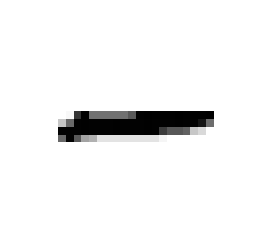

Actual label 4 , Predicted label 0


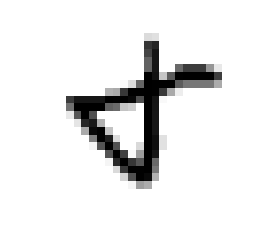

Actual label 2 , Predicted label 0


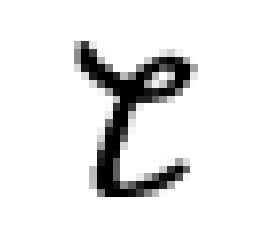

Actual label 4 , Predicted label 0


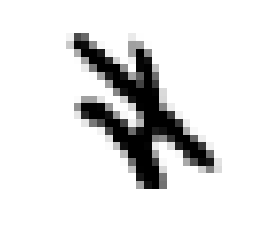

Actual label 6 , Predicted label 0


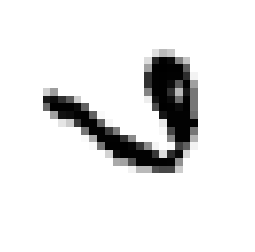

Actual label 8 , Predicted label 0


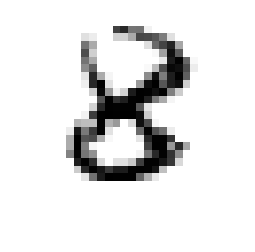

Actual label 7 , Predicted label 0


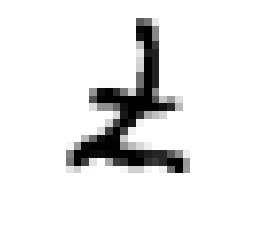

Actual label 8 , Predicted label 0


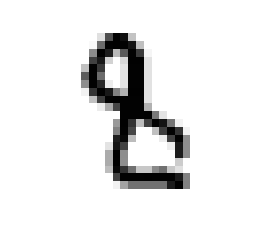

Actual label 3 , Predicted label 0


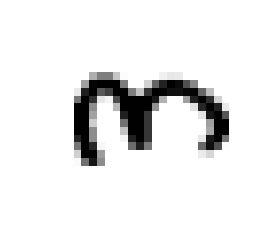

Actual label 3 , Predicted label 0


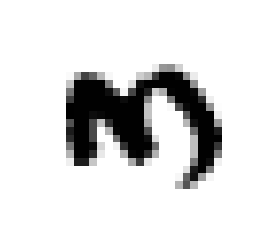

Actual label 7 , Predicted label 0


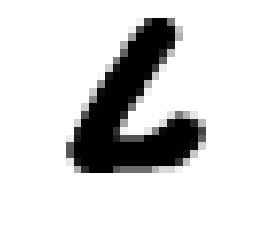

Actual label 9 , Predicted label 0


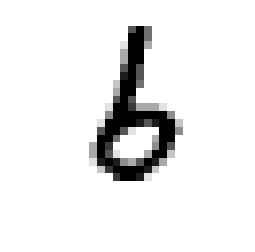

Actual label 8 , Predicted label 0


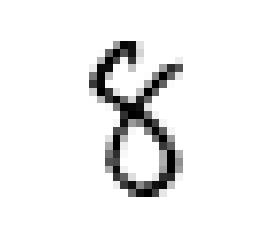

Actual label 3 , Predicted label 0


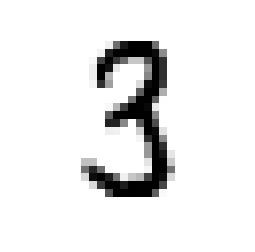

Actual label 7 , Predicted label 0


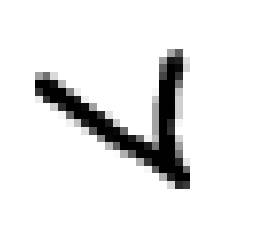

Actual label 5 , Predicted label 0


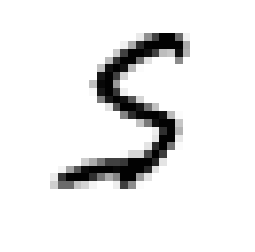

Actual label 5 , Predicted label 0


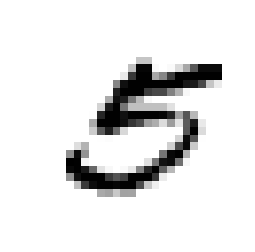

Actual label 3 , Predicted label 0


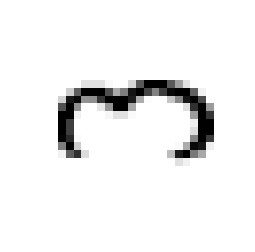

Actual label 9 , Predicted label 0


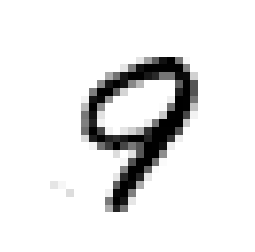

Actual label 7 , Predicted label 0


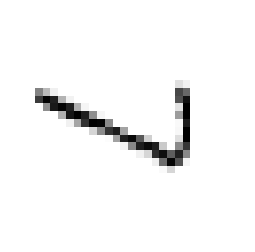

In [5]:
num_digits_to_check = 20
predictions = cnn_clf.predict(test_images[:num_digits_to_check])
for image, actual_label, predicted_label in zip(test_images[:num_digits_to_check], test_labels[:num_digits_to_check], predictions):
    print("Actual label", actual_label, ", Predicted label", predicted_label)
    show_image(image.reshape(28, 28))